In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-07-15 09:58:56.786028: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752598736.800027 1552681 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752598736.804363 1552681 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752598736.817027 1552681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752598736.817038 1552681 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752598736.817040 1552681 computation_placer.cc:177] computation placer alr

In [3]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [4]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [5]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# === Custom Layer ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load Model ===
dae = load_model("DAE.keras")


2025-07-15 09:59:33.717495: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# === Custom Layer ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load Model ===
cae = load_model("CAE.keras")


In [8]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# === Custom Layer ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load U-Net Denoising Model ===
custom_objects = {
    'Renormalize': Renormalize,
    'jensen_shannon_divergence_loss': jensen_shannon_divergence_loss
}

unet_model = load_model("UNet_Denoiser.keras", custom_objects=custom_objects)


In [ ]:
# Assuming unet_model has already been loaded with custom_objects

Base_JSD = np.zeros((1000000 // 1000 - 1, 1))
DAE_JSD = np.zeros((1000000 // 1000 - 1, 1))
CAE_JSD = np.zeros((1000000 // 1000 - 1, 1))
UNET_JSD = np.zeros((1000000 // 1000 - 1, 1))  # <-- Add U-Net tracker

print(Base_JSD.shape)
counter = -1
for i in range(1000, 1000000, 1000):
    counter += 1
    print(counter)
    
    sample = stochastic_density(ref_d, i)  # assumed function to sample from reference
    test = np.sum(sample, axis=2)

    if counter == 0:
        avg = test
    else:
        avg += test

    # Reshape input
    test_input = test.reshape(-1, 64, 64, 1)

    # JSD between raw sample and reference
    Base_JSD[counter] = jensen_shannon_divergence_loss(test.copy(), minorized_ref_d.copy())

    # JSD for each model prediction
    CAE_JSD[counter] = jensen_shannon_divergence_loss(cae.predict(test_input)[0, :, :, 0], minorized_ref_d.copy())
    DAE_JSD[counter] = jensen_shannon_divergence_loss(dae.predict(test_input)[0, :, :, 0], minorized_ref_d.copy())
    UNET_JSD[counter] = jensen_shannon_divergence_loss(unet_model.predict(test_input)[0, :, :, 0], minorized_ref_d.copy())  # <-- U-Net added

# Compute average sample and JSD score
avg = avg / (counter + 1)
avg_input = avg.reshape(-1, 64, 64, 1)
print("Average DAE JSD:", jensen_shannon_divergence_loss(dae.predict(avg_input)[0, :, :, 0], minorized_ref_d.copy()))
print("Average CAE JSD:", jensen_shannon_divergence_loss(cae.predict(avg_input)[0, :, :, 0], minorized_ref_d.copy()))
print("Average UNET JSD:", jensen_shannon_divergence_loss(unet_model.predict(avg_input)[0, :, :, 0], minorized_ref_d.copy()))


(999, 1)
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━

In [10]:
def generate_single_2d_density(ref_d, noise_level):
    noisy_3d = stochastic_density(ref_d, noise_level)  # shape: (64, 64, 64)
    projected_2d = np.sum(noisy_3d, axis=2)             # shape: (64, 64)
    return projected_2d

# Noise levels to randomly draw from
noise_levels = [10000 * (j + 1) for j in range(5)]  # [10000, 20000, ..., 50000]

# Sizes
num_train = 5000
num_val = 1000
num_test = 500

# Generate train set with mixed noise levels
x_train = np.zeros((num_train, 64, 64))
for i in range(num_train):
    noise_level = np.random.choice(noise_levels)
    x_train[i] = generate_single_2d_density(ref_d, noise_level)

# Generate val set with mixed noise levels
x_val = np.zeros((num_val, 64, 64))
for i in range(num_val):
    noise_level = np.random.choice(noise_levels)
    x_val[i] = generate_single_2d_density(ref_d, noise_level)

# Generate test set with fixed noise level
x_test = np.zeros((num_test, 64, 64))
for i in range(num_test):
    x_test[i] = generate_single_2d_density(ref_d, 100000)

print("Train, val, test generated")


# Average over all
total = num_train + num_val + num_test
train_sum = np.sum(x_train, axis=0)
val_sum = np.sum(x_val, axis=0)
test_sum = np.sum(x_test, axis=0)
AVG_TOTAL = (train_sum + val_sum + test_sum) / total



Train, val, test generated


In [11]:
# Compare to reference
avg_JSD =jensen_shannon_divergence_loss(avg, minorized_ref_d.copy())
AVG_TOTAL_JSD= jensen_shannon_divergence_loss(AVG_TOTAL, minorized_ref_d.copy())
print("average score of all samples is", avg_JSD)
print("JSD (avg total vs ref):",AVG_TOTAL_JSD )


average score of all samples is tf.Tensor(5.8878868e-08, shape=(), dtype=float32)
JSD (avg total vs ref): tf.Tensor(5.251934e-08, shape=(), dtype=float32)


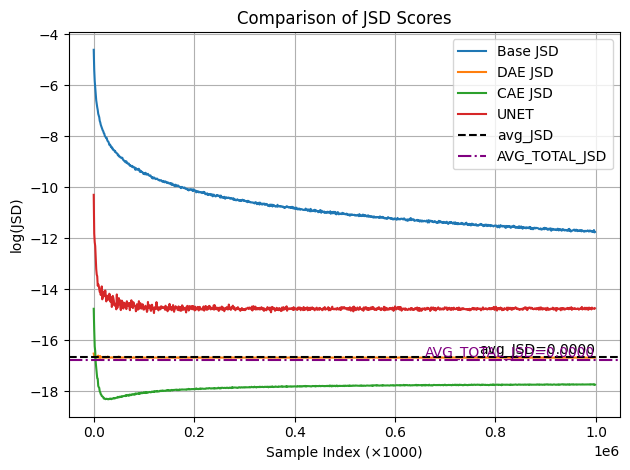

In [14]:
import numpy as np
import matplotlib.pyplot as plt

indx = np.arange(999)  # X-axis values

# Plotting JSD values
plt.plot(indx * 1000, np.log(Base_JSD), label='Base JSD')
plt.plot(indx * 1000, np.log(DAE_JSD), label='DAE JSD')
plt.plot(indx * 1000, np.log(CAE_JSD), label='CAE JSD')
plt.plot(indx * 1000, np.log(UNET_JSD), label='UNET')


# Plot horizontal lines for avg_JSD and AVG_TOTAL_JSD
plt.axhline(np.log(avg_JSD), color='black', linestyle='--', label='avg_JSD')
plt.axhline(np.log(AVG_TOTAL_JSD), color='purple', linestyle='-.', label='AVG_TOTAL_JSD')

# Optional: add markers at one point to show values
plt.text(indx[-1] * 1000, np.log(avg_JSD), f'avg_JSD={avg_JSD:.4f}', va='bottom', ha='right', color='black')
plt.text(indx[-1] * 1000, np.log(AVG_TOTAL_JSD), f'AVG_TOTAL_JSD={AVG_TOTAL_JSD:.4f}', va='bottom', ha='right', color='purple')

# Formatting
plt.xlabel("Sample Index (×1000)")
plt.ylabel("log(JSD)")
plt.legend()
plt.title("Comparison of JSD Scores")
plt.grid(True)
plt.tight_layout()
plt.show()


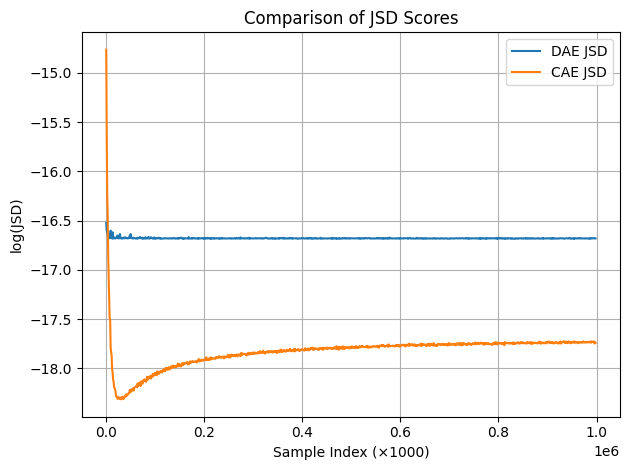

In [16]:
import numpy as np
import matplotlib.pyplot as plt

indx = np.arange(999)  # X-axis values

# Plotting JSD values
#plt.plot(indx * 1000, np.log(Base_JSD), label='Base JSD')
plt.plot(indx * 1000, np.log(DAE_JSD), label='DAE JSD')
plt.plot(indx * 1000, np.log(CAE_JSD), label='CAE JSD')
#plt.plot(indx * 1000, np.log(UNET_JSD), label='UNET')


# Plot horizontal lines for avg_JSD and AVG_TOTAL_JSD
#plt.axhline(np.log(avg_JSD), color='black', linestyle='--', label='avg_JSD')
#plt.axhline(np.log(AVG_TOTAL_JSD), color='purple', linestyle='-.', label='AVG_TOTAL_JSD')

# Optional: add markers at one point to show values
#plt.text(indx[-1] * 1000, np.log(avg_JSD), f'avg_JSD={avg_JSD:.4f}', va='bottom', ha='right', color='black')
#plt.text(indx[-1] * 1000, np.log(AVG_TOTAL_JSD), f'AVG_TOTAL_JSD={AVG_TOTAL_JSD:.4f}', va='bottom', ha='right', color='purple')

# Formatting
plt.xlabel("Sample Index (×1000)")
plt.ylabel("log(JSD)")
plt.legend()
plt.title("Comparison of JSD Scores")
plt.grid(True)
plt.tight_layout()
plt.show()


[4.77533604e-08]
[7.92693536e-05]
[2.09046266e-06]


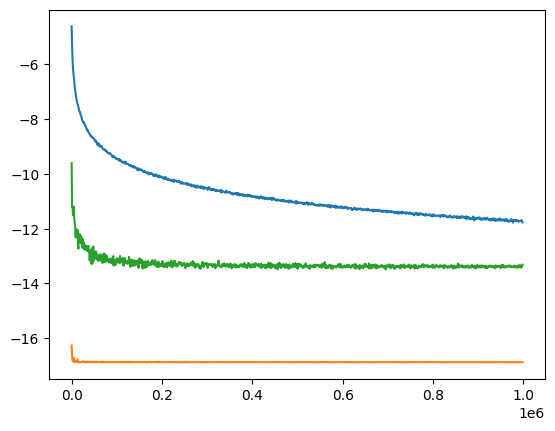

In [21]:
import numpy as np
import matplotlib.pyplot as plt
indx = np.arange(999) # Or your specific x-axis values
plt.plot(indx*1000, (np.log(Base_JSD)))
plt.plot(indx*1000, (np.log(DAE_JSD)))
plt.plot(indx*1000, (np.log(CAE_JSD)))
print(DAE_JSD[100])
print(Base_JSD[100])
print(CAE_JSD[100])

[4.77533604e-08]
[7.92693536e-05]
[2.09046266e-06]


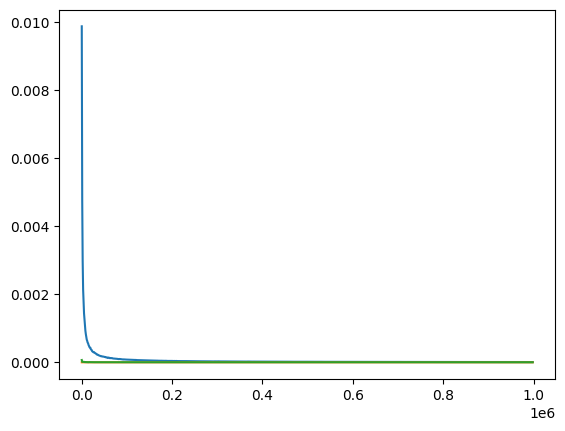

In [22]:
import numpy as np
import matplotlib.pyplot as plt
indx = np.arange(999) # Or your specific x-axis values
plt.plot(indx*1000, ((Base_JSD)))
plt.plot(indx*1000, ((DAE_JSD)))
plt.plot(indx*1000, ((CAE_JSD)))
print(DAE_JSD[100])
print(Base_JSD[100])
print(CAE_JSD[100])

[4.77533604e-08]
[7.92693536e-05]
[2.09046266e-06]


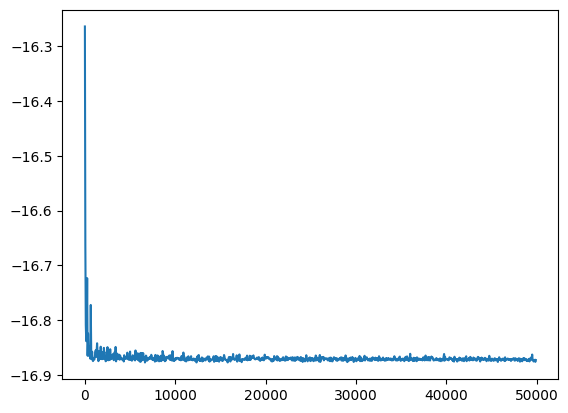

In [23]:
import numpy as np
import matplotlib.pyplot as plt
indx = np.arange(999) # Or your specific x-axis values
#plt.plot(indx, (np.log(Base_JSD)))
plt.plot(indx*50, (np.log(DAE_JSD)))
#plt.plot(indx, (np.log(CAE_JSD)))
print(DAE_JSD[100])
print(Base_JSD[100])
print(CAE_JSD[100])

[4.77533604e-08]
[7.92693536e-05]
[2.09046266e-06]


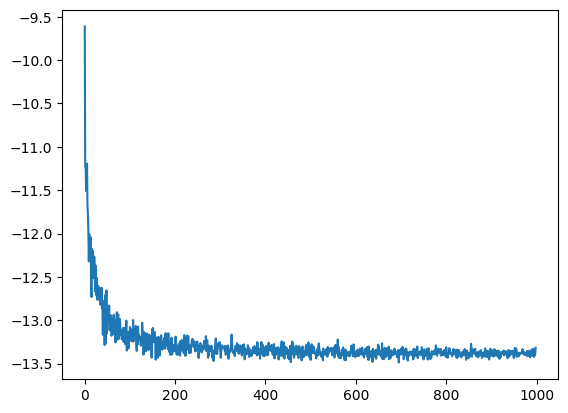

In [24]:
import numpy as np
import matplotlib.pyplot as plt
indx = np.arange(999) # Or your specific x-axis values
#plt.plot(indx, (np.log(Base_JSD)))
#plt.plot(indx, (np.log(DAE_JSD)))
plt.plot(indx, (np.log(CAE_JSD)))
print(DAE_JSD[100])
print(Base_JSD[100])
print(CAE_JSD[100])

In [15]:
CAE_JSD[100]

array([0.04329299])

In [25]:
y_test=np.sum(stochastic_density(ref_d,1000000),axis=2)
print(jensen_shannon_divergence_loss(y_test, minorized_ref_d.copy()))
print(dae.predict(y_test.reshape(-1, 64, 64, 1)).shape)

tf.Tensor(7.782823e-06, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
(1, 64, 64, 1)


In [27]:
print(jensen_shannon_divergence_loss(y_test, minorized_ref_d.copy()))
print(jensen_shannon_divergence_loss(dae.predict(y_test.reshape(-1, 64, 64, 1))[0,:,:,0], minorized_ref_d.copy()))
print(jensen_shannon_divergence_loss(cae.predict(y_test.reshape(-1, 64, 64, 1))[0,:,:,0], minorized_ref_d.copy()))

tf.Tensor(7.782823e-06, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
tf.Tensor(4.70406e-08, shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
tf.Tensor(1.5214599e-06, shape=(), dtype=float32)
